### Import Libraries

In [3]:
import pandas as pd

### Import data 

In [4]:
investing_data_path = "data/raw/investing_data.xlsx"
zf_data_path = "data/raw/zf.csv"
pd.options.display.max_columns = None

investing_data = pd.ExcelFile(investing_data_path)
ppi_data = investing_data.parse('ppi')
unemployment_data = investing_data.parse('unemployment')
cpi_data = investing_data.parse('core_cpi')
fed_rates_data = investing_data.parse('fed_int_rate')

# Load ZF futures data
zf_data = pd.read_csv(zf_data_path)
zf_data.head()

,date,open,high,low,close,volume
0,2010-01-04,114.250000,114.632812,114.062500,114.546875,295473
1,2010-01-05,114.609375,115.007812,114.593750,114.945312,393545
2,2010-01-06,114.882812,114.929688,114.640625,114.906250,473208
3,2010-01-07,114.820312,114.929688,114.578125,114.796875,357551
4,2010-01-08,114.734375,115.195312,114.554688,115.007812,357551


In [5]:
## Standardize Dates
for df in [ppi_data, unemployment_data, cpi_data, fed_rates_data]:
    df['Release Date'] = pd.to_datetime(df['Release Date'])
    df.columns = ['date','time','actual','forecast','previous']

# Convert ZF data date column to datetime
zf_data['date'] = pd.to_datetime(zf_data['date'])


In [6]:
fed_rates_data

,date,time,actual,forecast,previous
0,2024-12-18,14:00:00,0.0450,0.0450,0.0475
1,2024-11-07,14:00:00,0.0475,0.0475,0.0500
2,2024-09-18,13:00:00,0.0500,0.0525,0.0550
3,2024-07-31,13:00:00,0.0550,0.0550,0.0550
4,2024-06-12,13:00:00,0.0550,0.0550,0.0550
...,...,...,...,...,...
125,2009-06-24,13:15:00,0.0025,0.0025,0.0025
126,2009-04-29,13:15:00,0.0025,0.0025,0.0025
127,2009-03-18,13:15:00,0.0025,0.0025,0.0025
128,2009-01-28,14:15:00,0.0025,0.0025,0.0025


### Feature Engineering 

In [7]:
# Create new features for deviations and percentage changes
def add_deviation_features(df,prefix=""):
    df[f'{prefix}_actual'] = pd.to_numeric(df['actual'], errors='coerce')
    df[f'{prefix}_forecast'] = pd.to_numeric(df['forecast'], errors='coerce')
    df[f'{prefix}_previous'] = pd.to_numeric(df['previous'], errors='coerce')
    df[f'{prefix}_dev_forecast'] = df[f'{prefix}_actual'] - df[f'{prefix}_forecast']
    df[f'{prefix}_dev_previous'] = df[f'{prefix}_actual'] - df[f'{prefix}_previous']
    df[f'{prefix}_pct_deviation_forecast'] = (df[f'{prefix}_dev_previous'] / df[f'{prefix}_forecast']) * 100
    df = df.drop(['time','actual','forecast','previous'], axis=1) 
    return df

ppi_data = add_deviation_features(ppi_data,prefix='ppi')
unemployment_data = add_deviation_features(unemployment_data,prefix='unemployment')
cpi_data = add_deviation_features(cpi_data,prefix='cpi')
fed_rates_data = add_deviation_features(fed_rates_data,prefix='interest_rates')


In [8]:
fed_rates_data

,date,interest_rates_actual,interest_rates_forecast,interest_rates_previous,interest_rates_dev_forecast,interest_rates_dev_previous,interest_rates_pct_deviation_forecast
0,2024-12-18,0.0450,0.0450,0.0475,0.0000,-0.0025,-5.555556
1,2024-11-07,0.0475,0.0475,0.0500,0.0000,-0.0025,-5.263158
2,2024-09-18,0.0500,0.0525,0.0550,-0.0025,-0.0050,-9.523810
3,2024-07-31,0.0550,0.0550,0.0550,0.0000,0.0000,0.000000
4,2024-06-12,0.0550,0.0550,0.0550,0.0000,0.0000,0.000000
...,...,...,...,...,...,...,...
125,2009-06-24,0.0025,0.0025,0.0025,0.0000,0.0000,0.000000
126,2009-04-29,0.0025,0.0025,0.0025,0.0000,0.0000,0.000000
127,2009-03-18,0.0025,0.0025,0.0025,0.0000,0.0000,0.000000
128,2009-01-28,0.0025,0.0025,0.0025,0.0000,0.0000,0.000000


In [9]:
full_data = zf_data.merge(ppi_data, how='left',on='date')
full_data = full_data.merge(unemployment_data, how='left',on='date')
full_data = full_data.merge(cpi_data, how='left',on='date')
full_data = full_data.merge(fed_rates_data, how='left',on='date')

In [10]:
full_data.head()

,date,open,high,low,close,volume,ppi_actual,ppi_forecast,ppi_previous,ppi_dev_forecast,ppi_dev_previous,ppi_pct_deviation_forecast,unemployment_actual,unemployment_forecast,unemployment_previous,unemployment_dev_forecast,unemployment_dev_previous,unemployment_pct_deviation_forecast,cpi_actual,cpi_forecast,cpi_previous,cpi_dev_forecast,cpi_dev_previous,cpi_pct_deviation_forecast,interest_rates_actual,interest_rates_forecast,interest_rates_previous,interest_rates_dev_forecast,interest_rates_dev_previous,interest_rates_pct_deviation_forecast
0,2010-01-04,114.250000,114.632812,114.062500,114.546875,295473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,114.609375,115.007812,114.593750,114.945312,393545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-06,114.882812,114.929688,114.640625,114.906250,473208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-07,114.820312,114.929688,114.578125,114.796875,357551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-08,114.734375,115.195312,114.554688,115.007812,357551,NaN,NaN,NaN,NaN,NaN,NaN,0.1,0.101,0.1,-0.001,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
full_data.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'ppi_actual',
       'ppi_forecast', 'ppi_previous', 'ppi_dev_forecast', 'ppi_dev_previous',
       'ppi_pct_deviation_forecast', 'unemployment_actual',
       'unemployment_forecast', 'unemployment_previous',
       'unemployment_dev_forecast', 'unemployment_dev_previous',
       'unemployment_pct_deviation_forecast', 'cpi_actual', 'cpi_forecast',
       'cpi_previous', 'cpi_dev_forecast', 'cpi_dev_previous',
       'cpi_pct_deviation_forecast', 'interest_rates_actual',
       'interest_rates_forecast', 'interest_rates_previous',
       'interest_rates_dev_forecast', 'interest_rates_dev_previous',
       'interest_rates_pct_deviation_forecast'],
      dtype='object')

ZF Data Summary:
             close  ppi_dev_forecast  unemployment_dev_forecast  \
count  3730.000000        177.000000                 173.000000   
mean    118.103921          0.000051                  -0.001029   
std       5.559233          0.002982                   0.005354   
min     103.921875         -0.008000                  -0.064000   
25%     114.800781         -0.002000                  -0.001000   
50%     119.335938          0.000000                   0.000000   
75%     121.779297          0.002000                   0.001000   
max     126.210938          0.010000                   0.006000   

       cpi_dev_forecast  interest_rates_dev_forecast  
count        176.000000                 1.170000e+02  
mean          -0.000011                 5.930679e-20  
std            0.001166                 3.282661e-04  
min           -0.003000                -2.500000e-03  
25%           -0.001000                 0.000000e+00  
50%            0.000000                 0.000000e

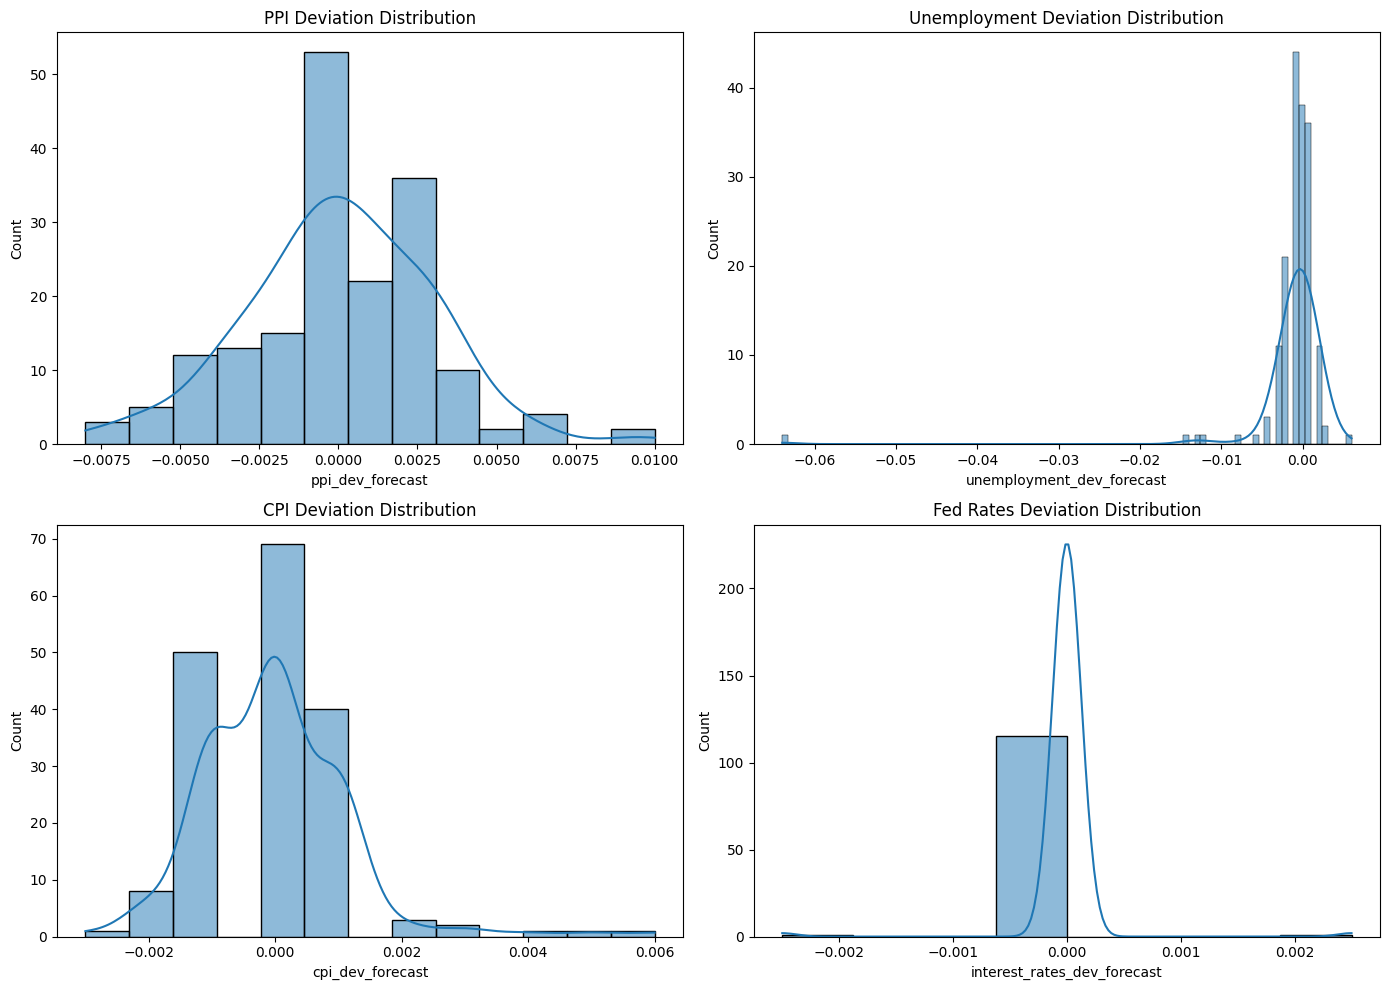

In [12]:
# Summary statistics
print("ZF Data Summary:")
print(full_data[['close', 'ppi_dev_forecast', 'unemployment_dev_forecast', 
               'cpi_dev_forecast', 'interest_rates_dev_forecast']].describe())

# Distribution of deviations
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(full_data['ppi_dev_forecast'], kde=True, ax=axes[0, 0]).set_title('PPI Deviation Distribution')
sns.histplot(full_data['unemployment_dev_forecast'], kde=True, ax=axes[0, 1]).set_title('Unemployment Deviation Distribution')
sns.histplot(full_data['cpi_dev_forecast'], kde=True, ax=axes[1, 0]).set_title('CPI Deviation Distribution')
sns.histplot(full_data['interest_rates_dev_forecast'], kde=True, ax=axes[1, 1]).set_title('Fed Rates Deviation Distribution')
plt.tight_layout()
plt.show()


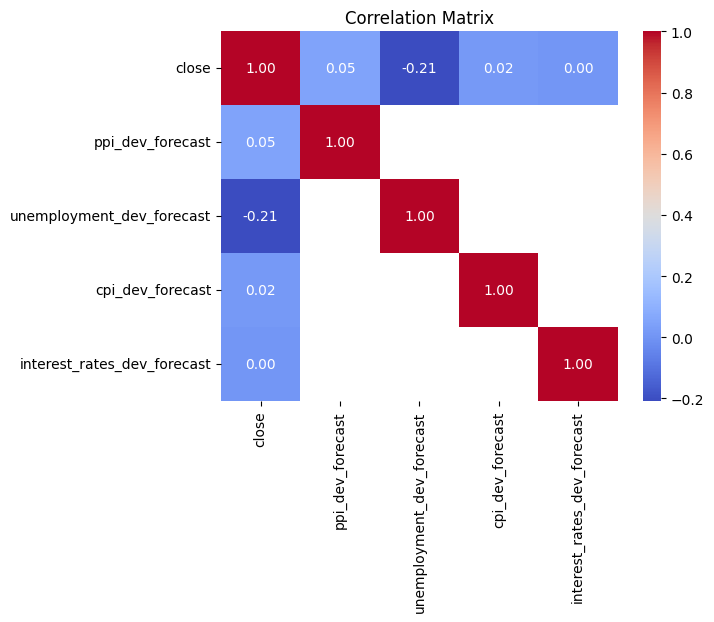

In [13]:
# Correlation matrix
correlation_matrix = full_data[['close', 'ppi_dev_forecast', 'unemployment_dev_forecast', 
               'cpi_dev_forecast', 'interest_rates_dev_forecast']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [14]:
full_data.head()

,date,open,high,low,close,volume,ppi_actual,ppi_forecast,ppi_previous,ppi_dev_forecast,ppi_dev_previous,ppi_pct_deviation_forecast,unemployment_actual,unemployment_forecast,unemployment_previous,unemployment_dev_forecast,unemployment_dev_previous,unemployment_pct_deviation_forecast,cpi_actual,cpi_forecast,cpi_previous,cpi_dev_forecast,cpi_dev_previous,cpi_pct_deviation_forecast,interest_rates_actual,interest_rates_forecast,interest_rates_previous,interest_rates_dev_forecast,interest_rates_dev_previous,interest_rates_pct_deviation_forecast
0,2010-01-04,114.250000,114.632812,114.062500,114.546875,295473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,114.609375,115.007812,114.593750,114.945312,393545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-06,114.882812,114.929688,114.640625,114.906250,473208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-07,114.820312,114.929688,114.578125,114.796875,357551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-08,114.734375,115.195312,114.554688,115.007812,357551,NaN,NaN,NaN,NaN,NaN,NaN,0.1,0.101,0.1,-0.001,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


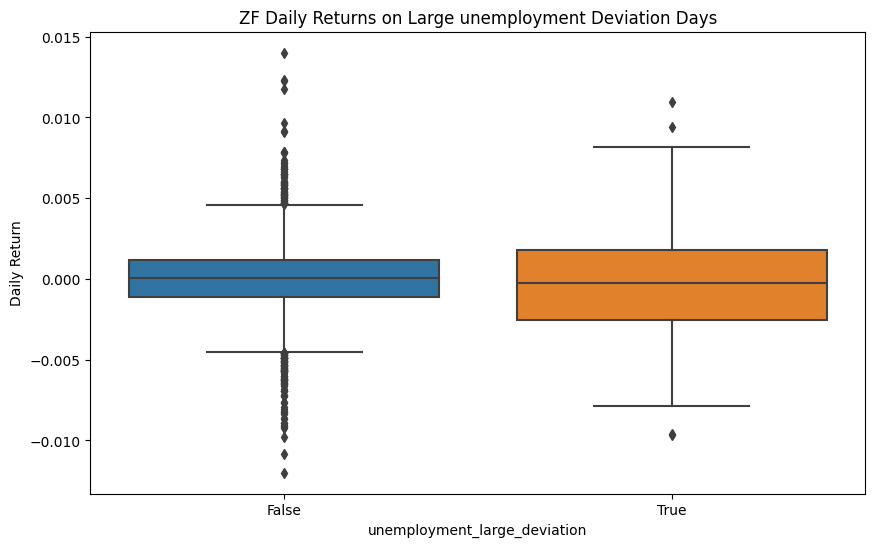

In [15]:
# Add a binary feature for large deviations
threshold = 0.001  # Example threshold for large deviations
show_indicator = "unemployment" # choose between ['ppi','cpi','uneployment','fed_rates']

full_data['ppi_large_deviation'] = abs(full_data['ppi_dev_forecast']) > threshold
full_data['unemployment_large_deviation'] = abs(full_data['unemployment_dev_forecast']) > threshold
full_data['cpi_large_deviation'] = abs(full_data['cpi_dev_forecast']) > threshold
full_data['fed_rates_large_deviation'] = abs(full_data['interest_rates_dev_forecast']) > threshold

# Boxplot of ZF returns on large deviation days
full_data['Daily Return'] = full_data['close'].pct_change()  # Calculate daily returns

plt.figure(figsize=(10, 6))
sns.boxplot(data=full_data, x=f'{show_indicator}_large_deviation', y='Daily Return')
plt.title(f'ZF Daily Returns on Large {show_indicator} Deviation Days')
plt.show()


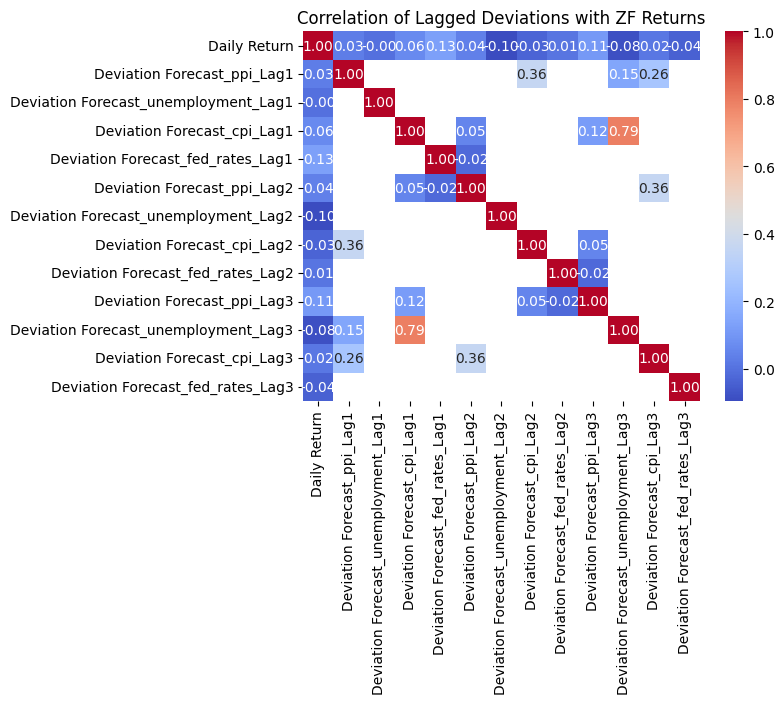

In [16]:
# Create lagged features for deviations
lags = [1, 2, 3]  # Example: 1-day, 2-day, 3-day lags
for lag in lags:
    full_data[f'Deviation Forecast_ppi_Lag{lag}'] = full_data['ppi_dev_forecast'].shift(lag)
    full_data[f'Deviation Forecast_unemployment_Lag{lag}'] = full_data['unemployment_dev_forecast'].shift(lag)
    full_data[f'Deviation Forecast_cpi_Lag{lag}'] = full_data['cpi_dev_forecast'].shift(lag)
    full_data[f'Deviation Forecast_fed_rates_Lag{lag}'] = full_data['interest_rates_dev_forecast'].shift(lag)

# Correlation of lags with ZF returns
lagged_features = [col for col in full_data.columns if 'Lag' in col]
correlations_with_lags = full_data[['Daily Return'] + lagged_features].corr()

sns.heatmap(correlations_with_lags, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Lagged Deviations with ZF Returns')
plt.show()


In [17]:
full_data

,date,open,high,low,close,volume,ppi_actual,ppi_forecast,ppi_previous,ppi_dev_forecast,ppi_dev_previous,ppi_pct_deviation_forecast,unemployment_actual,unemployment_forecast,unemployment_previous,unemployment_dev_forecast,unemployment_dev_previous,unemployment_pct_deviation_forecast,cpi_actual,cpi_forecast,cpi_previous,cpi_dev_forecast,cpi_dev_previous,cpi_pct_deviation_forecast,interest_rates_actual,interest_rates_forecast,interest_rates_previous,interest_rates_dev_forecast,interest_rates_dev_previous,interest_rates_pct_deviation_forecast,ppi_large_deviation,unemployment_large_deviation,cpi_large_deviation,fed_rates_large_deviation,Daily Return,Deviation Forecast_ppi_Lag1,Deviation Forecast_unemployment_Lag1,Deviation Forecast_cpi_Lag1,Deviation Forecast_fed_rates_Lag1,Deviation Forecast_ppi_Lag2,Deviation Forecast_unemployment_Lag2,Deviation Forecast_cpi_Lag2,Deviation Forecast_fed_rates_Lag2,Deviation Forecast_ppi_Lag3,Deviation Forecast_unemployment_Lag3,Deviation Forecast_cpi_Lag3,Deviation Forecast_fed_rates_Lag3
0,2010-01-04,114.250000,114.632812,114.062500,114.546875,295473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,114.609375,115.007812,114.593750,114.945312,393545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,0.003478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-06,114.882812,114.929688,114.640625,114.906250,473208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,-0.000340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-07,114.820312,114.929688,114.578125,114.796875,357551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,-0.000952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-08,114.734375,115.195312,114.554688,115.007812,357551,NaN,NaN,NaN,NaN,NaN,NaN,0.1,0.101,0.1,-0.001,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,False,0.001837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3725,2024-10-23,107.898438,107.929688,107.640625,107.664062,1101203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,-0.002389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3726,2024-10-24,107.656250,107.937500,107.648438,107.820312,1220757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,0.001451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3727,2024-10-25,107.757812,107.929688,107.593750,107.671875,1094845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,-0.001377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3728,2024-10-28,107.192001,107.214996,107.114998,107.453125,1348832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,-0.002032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


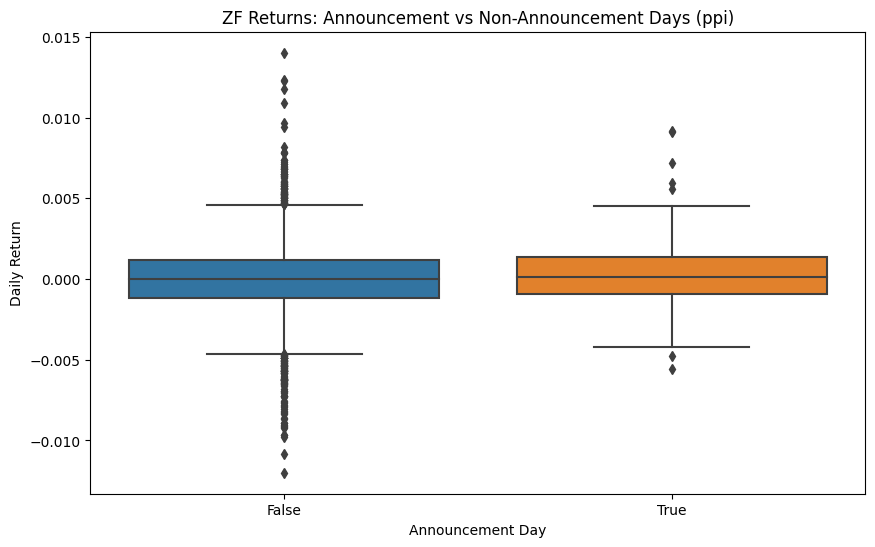

Average Returns After Announcements:
Return_1D_After   -0.000015
Return_2D_After   -0.000015
Return_3D_After   -0.000015
dtype: float64


In [18]:
# Add a flag for announcement days
indicator = 'ppi'
full_data['Announcement Day'] = full_data[f'{indicator}_dev_forecast'].notnull()

# ZF returns on announcement vs non-announcement days
plt.figure(figsize=(10, 6))
sns.boxplot(data=full_data, x='Announcement Day', y='Daily Return')
plt.title(f'ZF Returns: Announcement vs Non-Announcement Days ({indicator})')
plt.savefig(f"zf_return_on_announcements_{indicator}.png")
plt.show()

# Analyze returns 3 days before and after announcements
full_data['Return_1D_After'] = full_data['close'].shift(-1).pct_change()
full_data['Return_2D_After'] = full_data['close'].shift(-2).pct_change()
full_data['Return_3D_After'] = full_data['close'].shift(-3).pct_change()

print("Average Returns After Announcements:")
print(full_data[['Return_1D_After', 'Return_2D_After', 'Return_3D_After']].mean())


In [19]:
# Create a flag for each type of announcement
full_data['PPI Announcement'] = full_data['ppi_dev_forecast'].notnull()
full_data['CPI Announcement'] = full_data['cpi_dev_forecast'].notnull()
full_data['Unemployment Announcement'] = full_data['unemployment_dev_forecast'].notnull()
full_data['Fed Rates Announcement'] = full_data['interest_rates_dev_forecast'].notnull()

# Combine all announcements into a single flag
full_data['Any Announcement'] = (full_data['PPI Announcement'] | full_data['CPI Announcement'] |
                                full_data['Unemployment Announcement'] | full_data['Fed Rates Announcement'])

# Subset of ZF data for announcement days
announcement_days = full_data[full_data['Any Announcement']]
print(f"Total Announcement Days: {announcement_days.shape[0]}")


Total Announcement Days: 626


In [ ]:
announcement_days.head()

In [ ]:
# Calculate returns around announcements
announcement_days['1D Before Return'] = announcement_days['close'].pct_change(periods=1)
announcement_days['1D After Return'] = announcement_days['close'].shift(-1).pct_change()
announcement_days['2D After Return'] = announcement_days['close'].shift(-2).pct_change()

# Plot average returns before and after announcements
import seaborn as sns
import matplotlib.pyplot as plt

returns_data = announcement_days[['1D Before Return', '1D After Return', '2D After Return']].mean()
returns_data.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Average ZF Returns Around Announcement Days')
plt.ylabel('Average Return')
plt.xlabel('Time Period')
plt.show()


In [ ]:
# Calculate daily price changes (absolute)
announcement_days['Daily Price Change'] = abs(announcement_days['close'].pct_change())

# Plot average price change for each type of announcement
avg_changes = {
    'PPI': announcement_days[announcement_days['PPI Announcement']]['Daily Price Change'].mean(),
    'CPI': announcement_days[announcement_days['CPI Announcement']]['Daily Price Change'].mean(),
    'Unemployment': announcement_days[announcement_days['Unemployment Announcement']]['Daily Price Change'].mean(),
    'Fed Rates': announcement_days[announcement_days['Fed Rates Announcement']]['Daily Price Change'].mean()
}

pd.Series(avg_changes).plot(kind='bar', figsize=(10, 6), color='salmon')
plt.title('Average Daily Price Change on Announcement Days')
plt.ylabel('Average Price Change')
plt.xlabel('Indicator')
plt.savefig("average_daily_price_change_on_announcement_days.png")
plt.show()


In [ ]:
# Scatter plots of deviations vs. returns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.scatterplot(data=announcement_days, x='ppi_dev_forecast', y='1D After Return', ax=axes[0, 0])
axes[0, 0].set_title('PPI Deviation vs. 1D After Return')
sns.scatterplot(data=announcement_days, x='cpi_dev_forecast', y='1D After Return', ax=axes[0, 1])
axes[0, 1].set_title('CPI Deviation vs. 1D After Return')
sns.scatterplot(data=announcement_days, x='unemployment_dev_forecast', y='1D After Return', ax=axes[1, 0])
axes[1, 0].set_title('Unemployment Deviation vs. 1D After Return')
sns.scatterplot(data=announcement_days, x='interest_rates_dev_forecast', y='1D After Return', ax=axes[1, 1])
axes[1, 1].set_title('Fed Rates Deviation vs. 1D After Return')
plt.tight_layout()
plt.show()


# Eda Around Announcemets

In [ ]:
announcement_days.columns

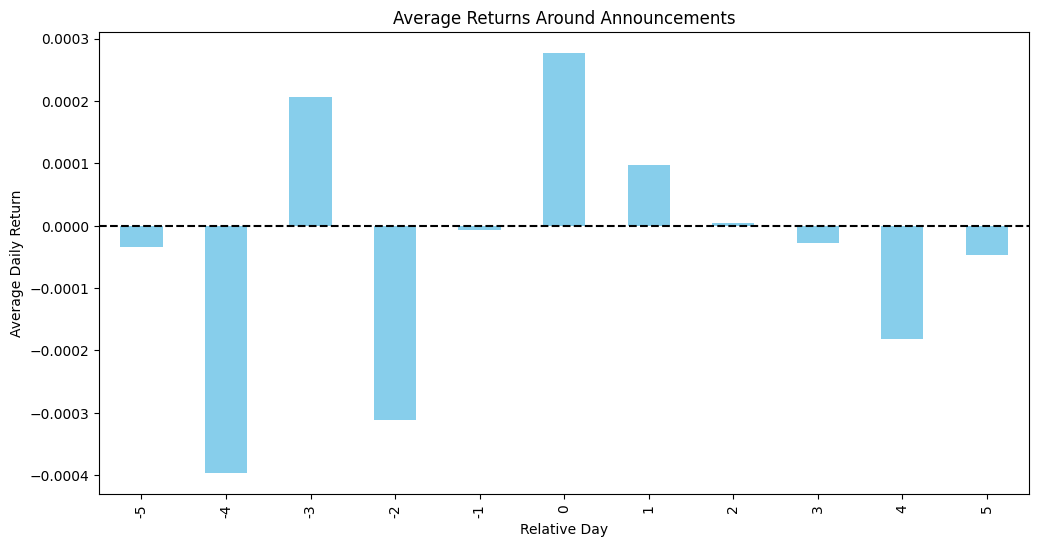

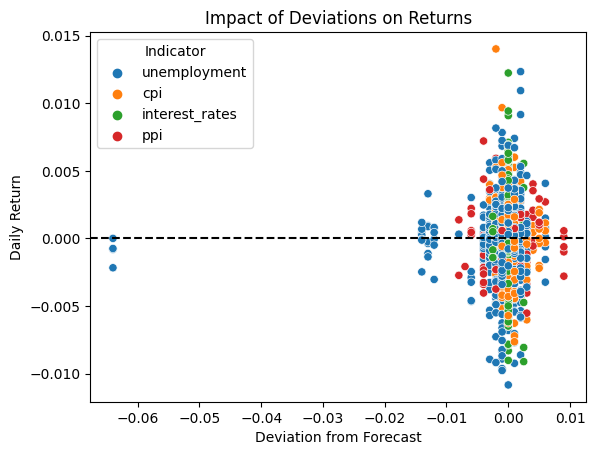

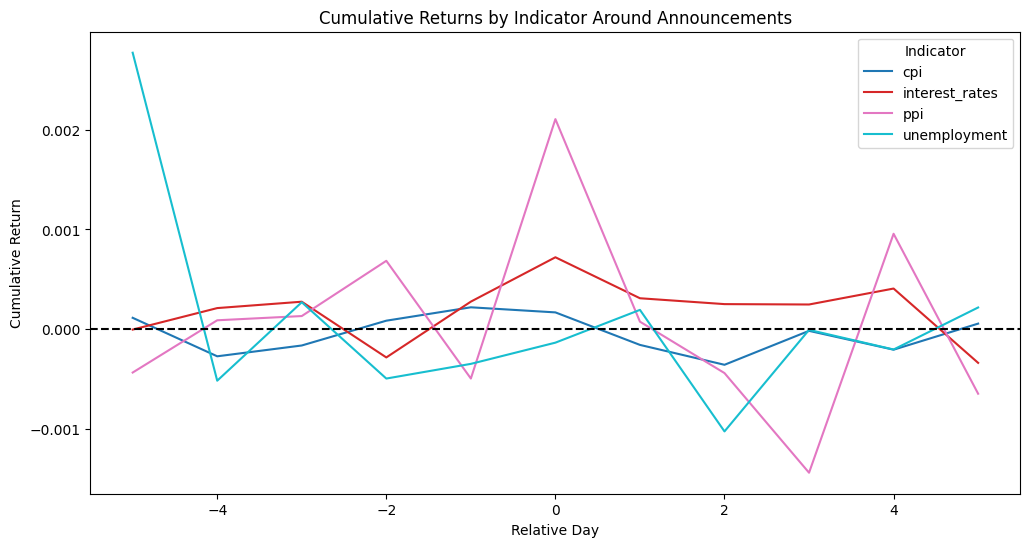

In [24]:
# Step 1: Associate ZF data with announcements and calculate deviations
window = 5  # Window size around announcements

# Add necessary columns to ZF dataset
full_data['RelativeDay'] = None
full_data['Indicator'] = None
full_data['Deviation'] = None

# Loop through each indicator to label ZF data
for indicator, df in [('ppi', ppi_data), ('cpi', cpi_data), ('unemployment', unemployment_data), ('interest_rates', fed_rates_data)]:
    actual_col = f'{indicator.lower()}_actual'
    forecast_col = f'{indicator.lower()}_forecast'
    
    for _, row in df.iterrows():
        announcement_date = row['date']
        deviation = row[actual_col] - row[forecast_col] if not pd.isnull(row[actual_col]) and not pd.isnull(row[forecast_col]) else None
        
        for offset in range(-window, window + 1):
            target_date = announcement_date + pd.Timedelta(days=offset)
            if target_date in full_data['date'].values:
                idx = full_data[full_data['date'] == target_date].index[0]
                full_data.at[idx, 'RelativeDay'] = offset
                full_data.at[idx, 'Indicator'] = indicator
                full_data.at[idx, 'Deviation'] = deviation

# Step 2: Filter relevant data
windowed_data = full_data[full_data['RelativeDay'].notnull()]

# Step 3: Analyze Patterns
import seaborn as sns

# Plot average returns around announcements by relative day
average_returns = windowed_data.groupby('RelativeDay')['Daily Return'].mean()
average_returns.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Average Returns Around Announcements')
plt.xlabel('Relative Day')
plt.ylabel('Average Daily Return')
plt.axhline(0, color='black', linestyle='--')
plt.show()

# Analyze deviation impacts on returns
sns.scatterplot(data=windowed_data, x='Deviation', y='Daily Return', hue='Indicator')
plt.title('Impact of Deviations on Returns')
plt.xlabel('Deviation from Forecast')
plt.ylabel('Daily Return')
plt.axhline(0, color='black', linestyle='--')
plt.show()

# Cumulative returns grouped by indicator and relative day
cumulative_returns = windowed_data.groupby(['RelativeDay', 'Indicator'])['Daily Return'].mean().unstack()
cumulative_returns.plot(figsize=(12, 6), cmap='tab10')
plt.title('Cumulative Returns by Indicator Around Announcements')
plt.xlabel('Relative Day')
plt.ylabel('Cumulative Return')
plt.axhline(0, color='black', linestyle='--')
plt.legend(title='Indicator')
plt.show()


In [ ]:
windowed_data.head(20)

In [ ]:
full_data['close'].diff()

In [ ]:
full_data.columns

In [26]:
windowed_data['RollingVolatility'] = (
    windowed_data.groupby('Indicator')['Daily Return']
    .transform(lambda x: x.rolling(5, center=True).std())
)


/var/folders/m8/yxnbqbdj74l_yx0j7kns7hhh0000gp/T/ipykernel_67866/2747276784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  windowed_data['RollingVolatility'] = (


/var/folders/m8/yxnbqbdj74l_yx0j7kns7hhh0000gp/T/ipykernel_67866/2795087333.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  windowed_data['RollingVolatility'] = (
/var/folders/m8/yxnbqbdj74l_yx0j7kns7hhh0000gp/T/ipykernel_67866/2795087333.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  windowed_data['CumulativeReturn'] = (
/var/folders/m8/yxnbqbdj74l_yx0j7kns7hhh0000gp/T/ipykernel_67866/2795087333.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

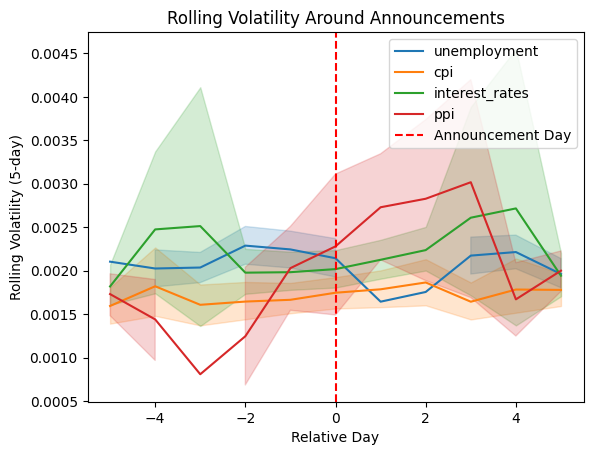

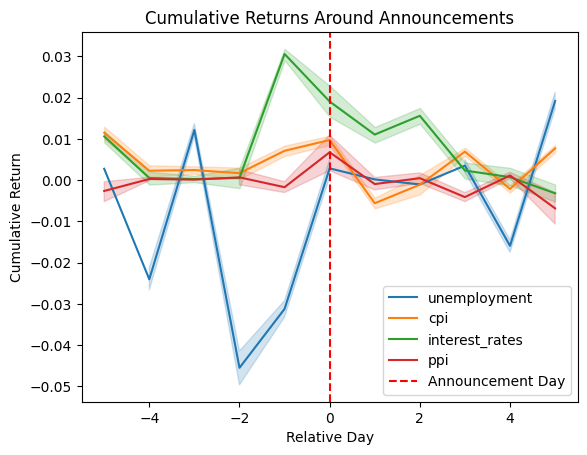

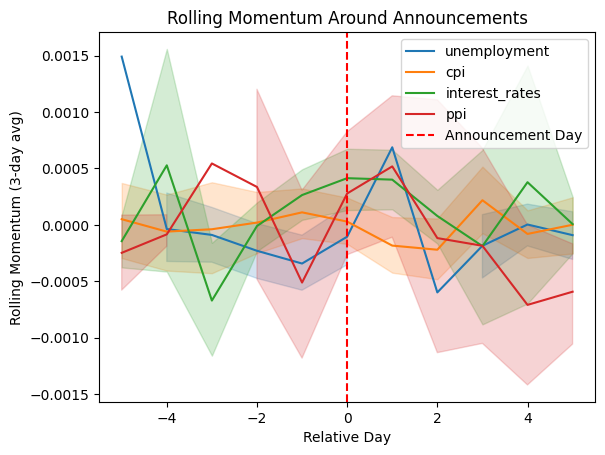

In [27]:
# Rolling volatility calculation (e.g., 5-day rolling std dev)
windowed_data['RollingVolatility'] = (
    windowed_data.groupby('Indicator')['Daily Return']
    .transform(lambda x: x.rolling(5, center=True).std())
)

# Cumulative returns (-5 to +5 days around announcements)
windowed_data['CumulativeReturn'] = (
    windowed_data.groupby(['Indicator', 'RelativeDay'])['Daily Return']
    .cumsum()
)

# Rolling momentum: 3-day rolling average returns
windowed_data['RollingMomentum'] = (
    windowed_data.groupby('Indicator')['Daily Return']
    .transform(lambda x: x.rolling(3, center=True).mean())
)

# Visualize Rolling Volatility
sns.lineplot(
    data=windowed_data, x='RelativeDay', y='RollingVolatility', hue='Indicator', palette='tab10'
)
plt.title('Rolling Volatility Around Announcements')
plt.xlabel('Relative Day')
plt.ylabel('Rolling Volatility (5-day)')
plt.axvline(0, color='red', linestyle='--', label='Announcement Day')
plt.legend()
plt.show()

# Visualize Cumulative Returns
sns.lineplot(
    data=windowed_data, x='RelativeDay', y='CumulativeReturn', hue='Indicator', palette='tab10'
)
plt.title('Cumulative Returns Around Announcements')
plt.xlabel('Relative Day')
plt.ylabel('Cumulative Return')
plt.axvline(0, color='red', linestyle='--', label='Announcement Day')
plt.legend()
plt.show()

# Visualize Rolling Momentum
sns.lineplot(
    data=windowed_data, x='RelativeDay', y='RollingMomentum', hue='Indicator', palette='tab10'
)
plt.title('Rolling Momentum Around Announcements')
plt.xlabel('Relative Day')
plt.ylabel('Rolling Momentum (3-day avg)')
plt.axvline(0, color='red', linestyle='--', label='Announcement Day')
plt.legend()
plt.show()


# ------------------

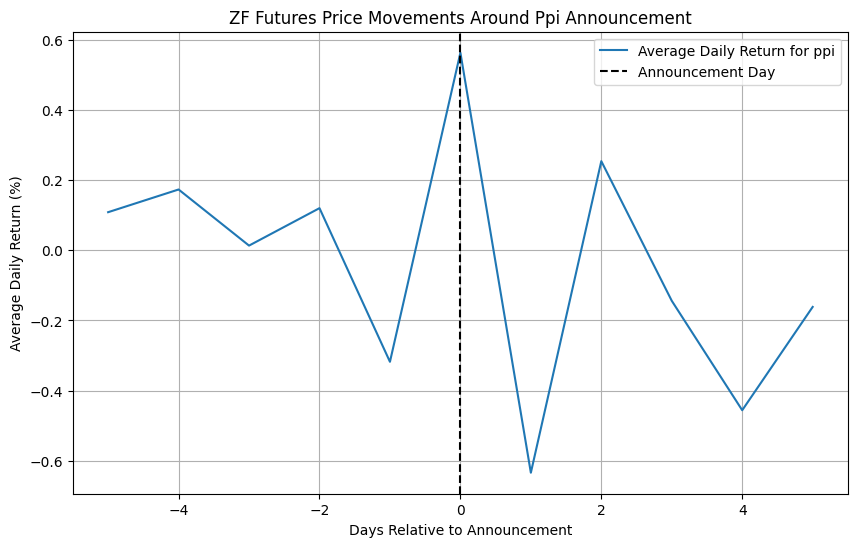

Positive deviation impact for ppi: 0.284% average return
Negative deviation impact for ppi: 0.840% average return


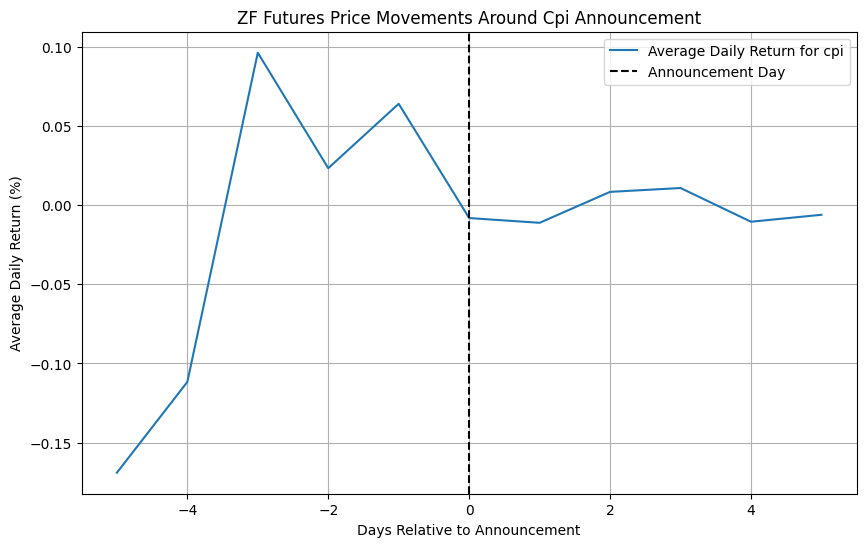

Positive deviation impact for cpi: -0.234% average return
Negative deviation impact for cpi: 0.111% average return


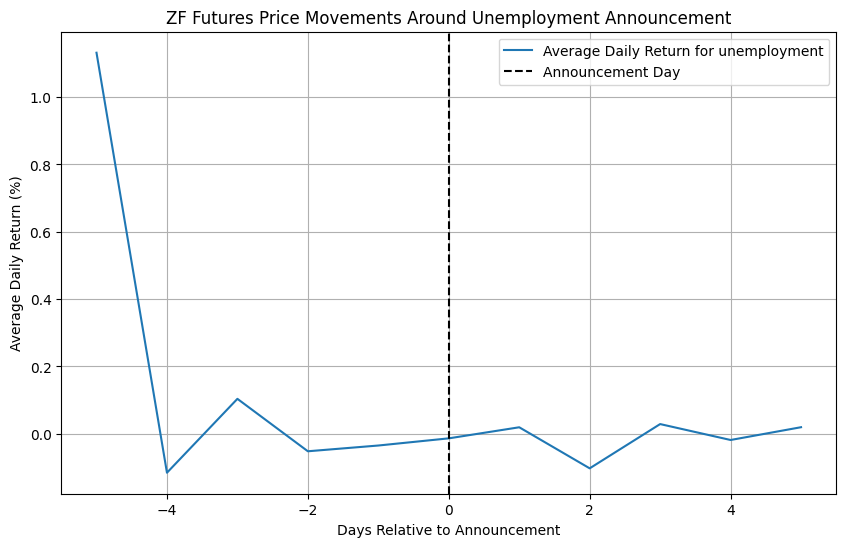

Positive deviation impact for unemployment: -0.036% average return
Negative deviation impact for unemployment: 0.000% average return


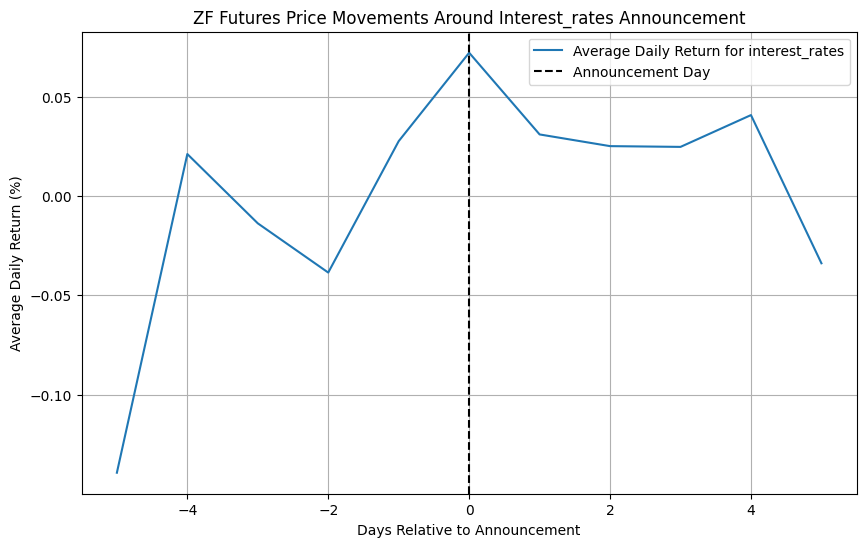

Positive deviation impact for interest_rates: 0.555% average return
Negative deviation impact for interest_rates: -0.085% average return


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Let's define the days window around announcements (±5 days)
announcement_window = 5
indicator_columns = {
    'ppi': 'ppi_actual',
    'cpi': 'cpi_actual',
    'unemployment': 'unemployment_actual',
    'interest_rates': 'interest_rates_actual'
}

# Create a function to calculate daily returns (percentage change)
def calculate_daily_returns(data):
    data['close'] = data['close'].pct_change() * 100  # Convert to percentage
    return data

# Iterate over the indicators and analyze price changes around each announcement
indicator_results = {}

for indicator, actual_column in indicator_columns.items():
    indicator_data = windowed_data[windowed_data['Indicator'] == indicator].copy()
    
    # Create a deviation column
    indicator_data[f'{indicator}_deviation'] = indicator_data[f'{actual_column}'] - indicator_data[f'{indicator}_forecast']
    
    # Calculate daily returns for ZF price movements around the announcement window
    indicator_data = calculate_daily_returns(indicator_data)
    
    # Focus on price movement around the announcement day (-5 to +5)
    windowed_returns = indicator_data.groupby('RelativeDay')['close'].mean()

    # Store results for plotting and further analysis
    indicator_results[indicator] = windowed_returns

    # Plot the price movement around the announcement for each indicator
    plt.figure(figsize=(10, 6))
    plt.plot(windowed_returns.index, windowed_returns.values, label=f'Average Daily Return for {indicator}')
    plt.title(f'ZF Futures Price Movements Around {indicator.capitalize()} Announcement')
    plt.xlabel('Days Relative to Announcement')
    plt.ylabel('Average Daily Return (%)')
    plt.axvline(0, color='black', linestyle='--', label='Announcement Day')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"zf_price_movements_around_{indicator}_announcement.png")
    plt.show()

    # Analyze price changes for positive and negative deviations
    positive_deviation = indicator_data[indicator_data[f'{indicator}_deviation'] > 0]
    negative_deviation = indicator_data[indicator_data[f'{indicator}_deviation'] < 0]

    pos_return = positive_deviation['close'].mean()
    neg_return = negative_deviation['close'].mean()

    print(f"Positive deviation impact for {indicator}: {pos_return:.3f}% average return")
    print(f"Negative deviation impact for {indicator}: {neg_return:.3f}% average return")

# Example output for a single indicator (CPI):
# CPI: Positive Deviation → +0.3%, Negative Deviation → -0.5%


In [ ]:
(114.546875-114.945312)/114.546875 * 100

In [ ]:
full_data.head(20)

In [ ]:
import matplotlib.pyplot as plt

# Function to calculate intraday volatility
def calculate_volatility(data):
    data['intraday_range'] = data['high'] - data['low']
    return data

# Apply volatility calculation
windowed_data = calculate_volatility(windowed_data)

# Analyze volatility based on conditions
for indicator, actual_column in indicator_columns.items():
    forecast_column = f"{indicator}_forecast"
    previous_column = f"{indicator}_previous"

    # Filter for the current indicator
    indicator_data = windowed_data[windowed_data["Indicator"] == indicator].copy()

    # Conditions
    indicator_data['Actual ≠ Previous'] = indicator_data[actual_column] != indicator_data[previous_column]
    indicator_data['Forecast Miss'] = indicator_data[actual_column] != indicator_data[forecast_column]

    # Calculate average volatility for each condition
    avg_volatility = indicator_data.groupby(['Actual ≠ Previous', 'Forecast Miss'])['intraday_range'].mean()

    # Plotting
    plt.figure(figsize=(12, 6))
    avg_volatility.unstack().plot(kind='bar', figsize=(10, 6), rot=0)
    plt.title(f'{indicator.capitalize()} Announcement: Average Volatility (ZF Futures)')
    plt.ylabel('Average Intraday Range')
    plt.xlabel('Actual ≠ Previous')
    plt.legend(title='Forecast Miss', labels=['No', 'Yes'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Function to calculate intraday volatility
def calculate_volatility(data):
    data['Intraday Range'] = data['high'] - data['low']
    return data

# Apply volatility calculation
windowed_data = calculate_volatility(windowed_data)

# Scatter plot analysis for each indicator
for indicator, actual_column in indicator_columns.items():
    forecast_column = f"{indicator}_forecast"
    previous_column = f"{indicator}_previous"

    # Filter for the current indicator
    indicator_data = windowed_data[windowed_data["Indicator"] == indicator].copy()

    # Drop rows with missing values in relevant columns
#     indicator_data = indicator_data.dropna(subset=[actual_column, forecast_column, previous_column])

    # Define refined scenarios
    def determine_condition(row):
        
        if pd.isna(row[actual_column]):
            return f"no_{indicator}_announcement"
        if row[actual_column] == row[forecast_column] and row[actual_column] == row[previous_column]:
            return "Neutral Impact"
        elif row[actual_column] != row[forecast_column] and row[actual_column] == row[previous_column]:
            return "Surprise Change"
        elif row[actual_column] == row[forecast_column] and row[actual_column] != row[previous_column]:
            return "Trend Shift"
        elif row[actual_column] != row[forecast_column] and row[actual_column] != row[previous_column]:
            return "Double Surprise"
        else:
            return "Marginal Change"

    indicator_data['Condition'] = indicator_data.apply(determine_condition, axis=1)

    # Debugging output: Count of each condition
    condition_counts = indicator_data['Condition'].value_counts()
    print(f"Condition counts for {indicator} announcements:\n{condition_counts}\n")

    # Create a bubble scatter plot
    plt.figure(figsize=(12, 8))
    sizes = (indicator_data['Intraday Range'] - indicator_data['Intraday Range'].min() + 1) * 50  # Scale bubble sizes
    condition_colors = {
        "Neutral Impact": "blue",
        "Surprise Change": "orange",
        "Trend Shift": "green",
        "Double Surprise": "red",
        "Marginal Change": "purple"
    }

    for condition, color in condition_colors.items():
        subset = indicator_data[indicator_data['Condition'] == condition]
        plt.scatter(
            subset['date'],
            subset['Intraday Range'],
            s=sizes[subset.index],
            label=condition,
            color=color,
            alpha=0.7,
            edgecolor='k'
        )

    plt.title(f"Bubble Scatter Plot of Volatility for {indicator.capitalize()} Announcements")
    plt.xlabel("Date")
    plt.ylabel("Intraday Range (ZF High - ZF Low)")
    plt.grid(alpha=0.3)
    plt.legend(title="Condition")
    plt.show()


In [ ]:
ppi_data.query("ppi_actual != ppi_forecast and ppi_actual != ppi_previous")

In [ ]:
zf_rates = zf_data.merge(fed_rates_data,how='left', on='date')
zf_rates['is_announcement'] = zf_rates[['interest_rates_actual']].notnull()
zf_rates['volatility'] = zf_rates['high'] - zf_rates['low']
zf_rates['zf_change'] = zf_rates['close'].diff()

In [ ]:
zf_rates.columns

In [1]:
# Define refined scenarios
def determine_condition(row):
    
    # Check for NaN values and handle them
    if pd.isna(row['interest_rates_actual']) or pd.isna(row['interest_rates_forecast']) or pd.isna(row['interest_rates_previous']):
        return "no_announcement"
    
    if row['interest_rates_actual'] == row['interest_rates_forecast'] and row['interest_rates_actual'] == row['interest_rates_previous']:
        return "Neutral Impact"
    elif row['interest_rates_actual'] != row['interest_rates_forecast'] and row['interest_rates_actual'] == row['interest_rates_previous']:
        return "Surprise Change"
    elif row['interest_rates_actual'] == row['interest_rates_forecast'] and row['interest_rates_actual'] != row['interest_rates_previous']:
        return "Trend Shift"
    elif row['interest_rates_actual'] != row['interest_rates_forecast'] and row['interest_rates_actual'] != row['interest_rates_previous']:
        return "Double Surprise"
    else:
        return "Marginal Change"
    
zf_rates['condition'] = zf_rates.apply(determine_condition,axis=1)

NameError: name 'zf_rates' is not defined

In [2]:
zf_rates

NameError: name 'zf_rates' is not defined

In [ ]:
import plotly.express as px
fig = px.scatter(zf_rates, x="condition", y="volatility", color="condition",
                 size='volume')
fig.show()

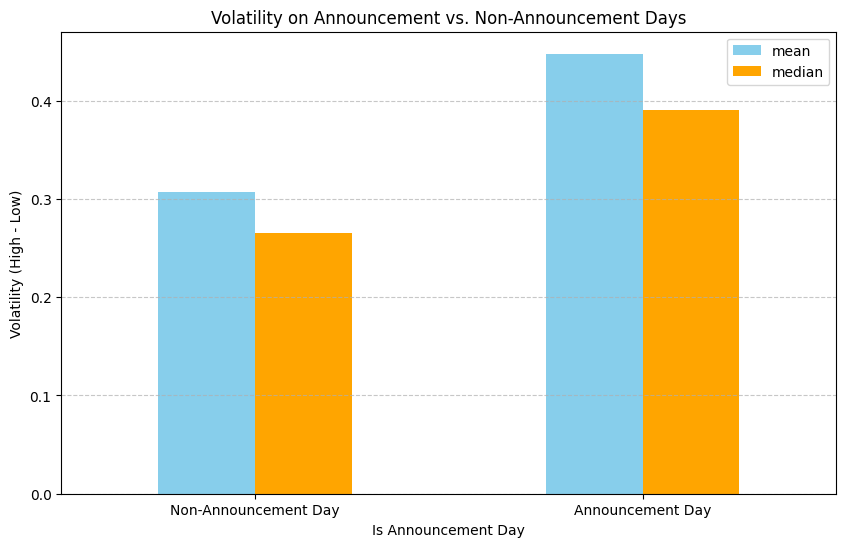

In [21]:
# Calculate daily price range as volatility
zf_data['Volatility'] = zf_data['high'] - zf_data['low']

# Label announcement days
zf_data['Is Announcement Day'] = zf_data['date'].isin(announcement_days['date'])

# Group by announcement day status
volatility_summary = zf_data.groupby('Is Announcement Day')['Volatility'].agg(['mean', 'median'])

# Plot average and median volatility
volatility_summary.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'], legend=True)
plt.title("Volatility on Announcement vs. Non-Announcement Days")
plt.ylabel("Volatility (High - Low)")
plt.xlabel("Is Announcement Day")
plt.xticks(ticks=[0, 1], labels=["Non-Announcement Day", "Announcement Day"], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("Volatility_on_Announcement_vs._Non-Announcement_Days.png")
plt.show()


/var/folders/m8/yxnbqbdj74l_yx0j7kns7hhh0000gp/T/ipykernel_67866/2746788056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  windowed_data['Volatility'] = windowed_data['high'] - windowed_data['low']


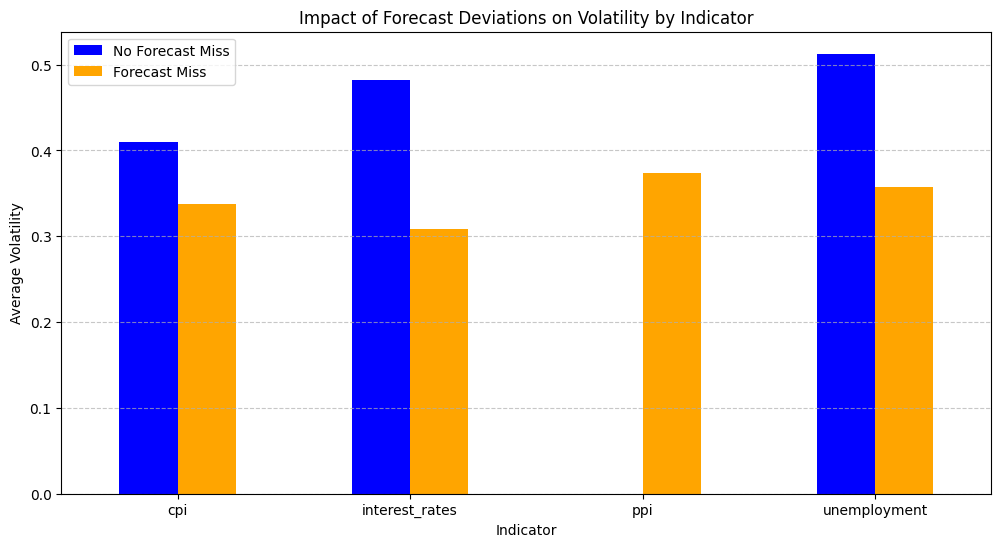

In [32]:
# Analyze forecast deviations
windowed_data['Volatility'] = windowed_data['high'] - windowed_data['low']

sensitivity_data = windowed_data.copy()

sensitivity_data['Forecast Miss'] = sensitivity_data.apply(
    lambda row: row[f"{row['Indicator']}_actual"] != row[f"{row['Indicator']}_forecast"], axis=1
)

# Group by indicator and forecast miss
sensitivity_summary = sensitivity_data.groupby(['Indicator', 'Forecast Miss'])['Volatility'].mean().unstack()

# Plot sensitivity to forecast deviations
sensitivity_summary.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])
plt.title("Impact of Forecast Deviations on Volatility by Indicator")
plt.ylabel("Average Volatility")
plt.xlabel("Indicator")
plt.xticks(rotation=0)
plt.legend(["No Forecast Miss", "Forecast Miss"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [33]:
ppi_data.head()

,date,ppi_actual,ppi_forecast,ppi_previous,ppi_dev_forecast,ppi_dev_previous,ppi_pct_deviation_forecast
0,2025-01-14,NaN,0.003,0.004,NaN,NaN,NaN
1,2024-12-12,0.004,0.002,0.003,0.002,0.001,50.0
2,2024-11-14,0.002,0.002,0.001,0.000,0.001,50.0
3,2024-10-11,0.000,0.001,0.002,-0.001,-0.002,-200.0
4,2024-09-12,0.002,0.001,0.000,0.001,0.002,200.0
